In [1]:
from matplotlib import patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
from gmm import GMM

In [2]:
import scipy.stats as st
import sys
sys.path.append("..")
from K_Means.k_means import KMeansPlusPlus

class GMM:
    def __init__(self, k):
        self.k = k
        self.means = []
        self.covariances = []
        self.pis = []
        self.gammas = []

    def fit(self, data, eps=1e-4):
        """
        :params data: np.array of shape (..., dim)
                                  where dim is number of dimensions of point
        """
        data = np.array(data, np.float)
        self._initialize_params(data)
        
        old_means = self.get_means()
        self._E_step(data)
        self._M_step(data)
        
        while np.sum(np.square(old_means - self.means)) > eps:
            print(np.sum(np.square(old_means - self.means)))
            old_means = self.get_means()
            self._E_step(data)
            self._M_step(data)
            
    def _initialize_params(self, data):
        
        kmpp = KMeansPlusPlus(self.k)
        kmpp.fit(data)
        
        _, self.means = kmpp.predict(data[:1])
        
        self.covariances = np.array([np.identity(data.shape[-1])] * self.k) 
        self.pis = np.ones(self.k, np.float)/self.k
        

    def _E_step(self, data):
        normalpdfs = [st.multivariate_normal(self.means[i], self.covariances[i]).pdf
                      for i in range(self.k)]
        self.gammas = np.zeros((data.shape[0], self.k), np.float)
        for i in range(data.shape[0]):
            
            self.gammas[i] = self.pis * np.array([pdf(data[i]) for pdf in normalpdfs])
            self.gammas[i] /= self.gammas[i].sum()

    def _M_step(self, data):
        gammaSums = self.gammas.sum(axis=0)
        self.means = self.gammas.T.dot(data) /gammaSums[None].T
        
        self.covariances = np.zeros_like(self.covariances)
        for j in range(self.k):
            for i in range(data.shape[0]):
                a = (data[i] - self.means[j])
                self.covariances[j] += self.gammas[i,j] * np.outer(a, a)
            self.covariances[j] /= gammaSums[j]
            
        self.pis = gammaSums/gammaSums.sum()
        
    def predict(self, data):
        """
        :param data: np.array of shape (..., dim)
        :return: np.array of shape (...) without dims
                         each element is integer from 0 to k-1
        """
        normalpdfs = [st.multivariate_normal(self.means[i], self.covariances[i]).pdf
                      for i in range(self.k)]
        return np.array([self._pred(d, normalpdfs) for d in data])

    def _pred(self, x, normalpdfs):
        return np.argmax([pdf(x) for pdf in normalpdfs])
        
        
    def get_means(self):
        return self.means.copy()

    def get_covariances(self):
        return self.covariances.copy()

    def get_pis(self):
        return self.pis.copy()

In [3]:
def get_ellipse_from_covariance(matrix, std_multiplier=2):
    values, vectors = np.linalg.eig(matrix)
    maxI = np.argmax(values)
    large, small = values[maxI], values[1 - maxI]
    return (std_multiplier * np.sqrt(large),
            std_multiplier * np.sqrt(small),
            np.rad2deg(np.arccos(vectors[0, 0])))

In [4]:
cols = ["bx", "gx" ,"rx" ,"cx" ,"mx" ,"yx" ,"kx" ,"bo" ,"go" ,"ro" ,"co" ,"mo" ,
        "yo" ,"ko", "b^" ,"g^" ,"r^" ,"c^" ,"m^" ,"y^" ,"k^"]

In [5]:
def run_gmm(dataPath, name, k):
    df = pd.read_csv(dataPath)
    global data
    data = np.array(df[['X', 'Y']], np.float)/100000
    plt.clf()
    plt.scatter(data[:, 0], data[:, 1], s=3, color='blue')

    global gmm

    gmm = GMM(k)
    gmm.fit(data)
    mean = gmm.get_means()
    sigma = gmm.get_covariances()
    pi = gmm.get_pis()

    # Plot ellipses for each of covariance matrices.
    for k in range(len(sigma)):
        h, w, angle = get_ellipse_from_covariance(sigma[k])
        e = patches.Ellipse(mean[k], w, h, angle=angle)
        e.set_alpha(np.power(pi[k], .3))
        e.set_facecolor('red')
        plt.axes().add_artist(e)
    plt.savefig('covariances_{}_{}'.format(dataPath, name).replace('.','_'))
    plt.show()
    
    pred = gmm.predict(data)
    plt.figure(figsize=(20,10))
    for i in range(k):
        plt.scatter(data[pred==i,0],data[pred==i,1],None,*cols[i])
    plt.show()

1.2646396136406552
0.2532684015555439
0.1341101622416921
0.10993111571367857
0.061583783397020884
0.007231766702161493
0.002191617356718161
0.0009352989187366129
0.0006142755928253748
0.0006395751177208897
0.0007557765033894409
0.0008358960303682619
0.0008447835276014702
0.0007935650497085005
0.0007067108801977395
0.0006066401775031517
0.0005085116241222265
0.00042056581872517454
0.0003467295125102029
0.00028808653789836165
0.00024310377119832422
0.0002086401221964216
0.00018154810848451162
0.00015996223271112558
0.00014382434471263623
0.00013436855997047477
0.000133211809541172
0.00014205192690045895
0.00016294026745891865
0.0001983031660214542
0.00024966472790957563
0.00031395882560745624
0.00037802571850313057
0.00041752807025534095
0.00040943896378979784
0.0003519499774428965
0.00026757103399143394
0.00018432402003030858
0.00011855700654279704


C:\Users\hovhannes.sahakyan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


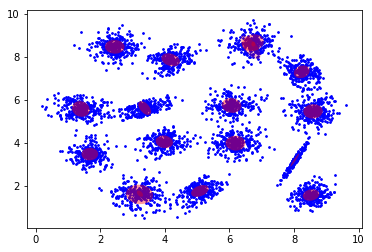

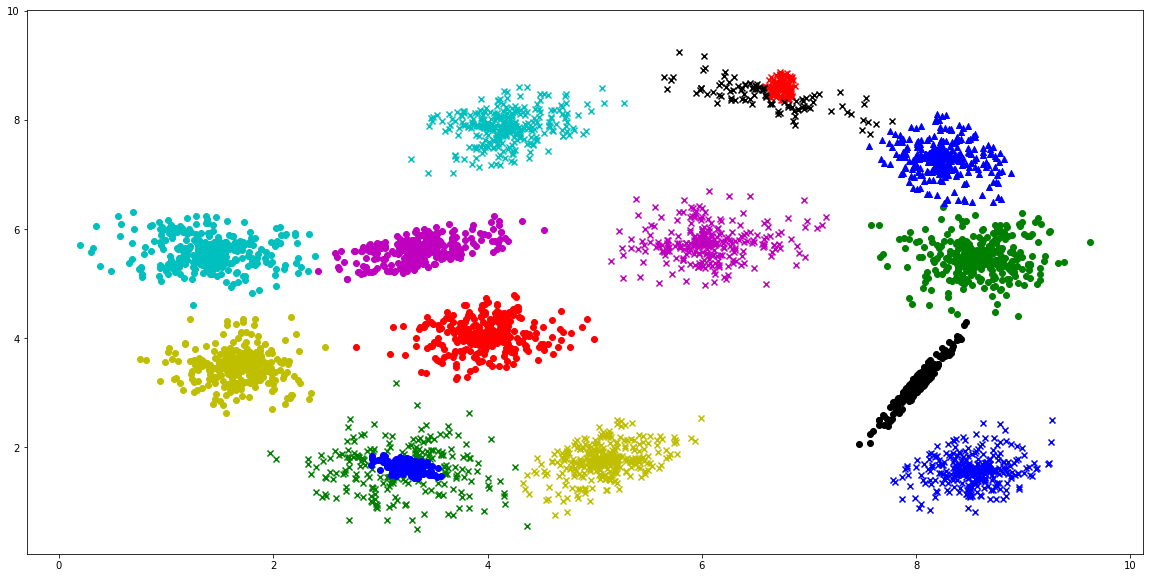

In [6]:
k=18
run_gmm("sparse_clusters.csv", "hov", k)

1.9974487617728456
0.07092811802363758
0.05555351871743147
0.03683223120970521
0.023076240866375417
0.017455657048121936
0.01627374149388166
0.012218068566697828
0.009637906518742441
0.009835602043429236
0.010467495412934227
0.010504176483393655
0.009822385036493462
0.008657265887035904
0.007209189810176949
0.005429607592621302
0.003989376246258728
0.0028778174099610187
0.0022224914502521043
0.0018726287091665186
0.0016451472926270654
0.0014499038682203806
0.0012671698760971393
0.0011171776328446235
0.001022158015008414
0.0009767070088681845
0.0009521483070417681
0.000924045509765575
0.0008862037892503604
0.0008429889992530496
0.0007991804875875296
0.0007568177845326697
0.0007157268456150813
0.0006744467882715773
0.000630989083094488
0.000583577144281694
0.0005313104949514315
0.00047455895047269673
0.00041500222052566824
0.0003554371662289719
0.0002996046183808255
0.0002522791206876788
0.00021966868476263831
0.00020943333974723574
0.00022754357473391159
0.000267251599053101
0.000297048

C:\Users\hovhannes.sahakyan\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


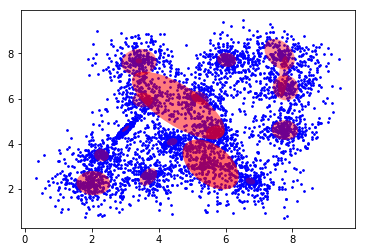

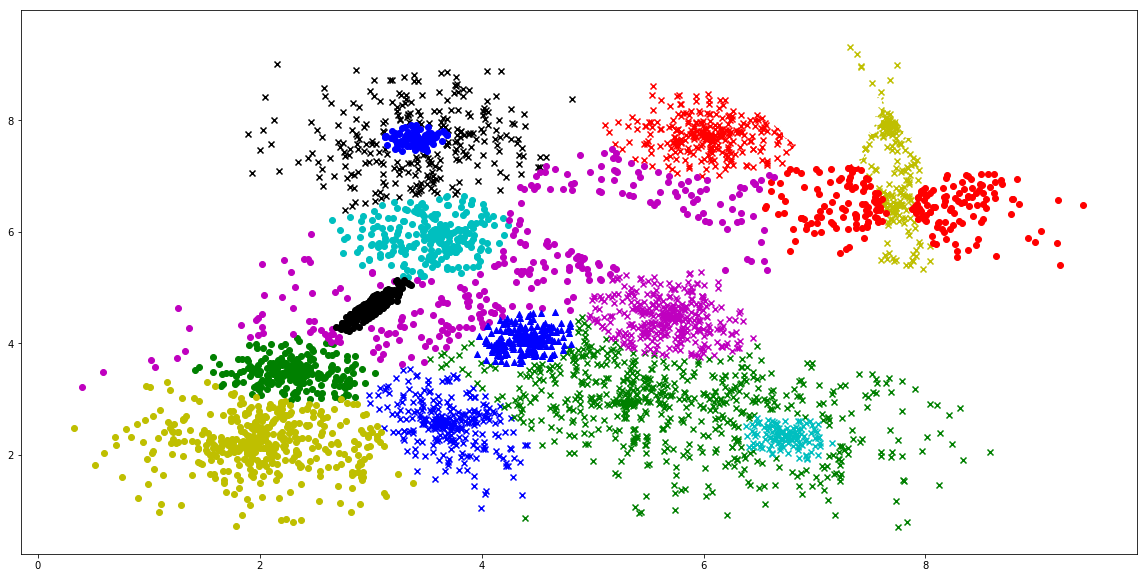

In [7]:
k=18
run_gmm("dense_clusters.csv", "hov", k)